* In this notebook, we will use groundtruth building foodprints dataset from [mapping-challenge](https://www.aicrowd.com/challenges/mapping-challenge-old) hosted on Aicrowd for building footprint segmentation.

* First, We will convert COCO Annotation Format dataset into building footprint masks required for segmentation model training.

* We will train DeeplabV3+ (https://arxiv.org/abs/2104.01263) with Resnet101 backbone for building segmentation. We will also leverage the weighted boundary mask technique mentioned in the research paper for improved building segmentation.


# Installation

In [1]:
!pip install pycocotools
!pip install torchsummary
!pip install pandarallel
!pip install lightning

  Preparing metadata (setup.py) ... done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16674 sha256=feb3d0e3935c1ed9fc91c5971b6212b055bdd66eb1dc83560cd5be748b710f16
  Stored in directory: /root/.cache/pip/wheels/46/f9/0d/40c9cd74a7cb8dc8fe57e8d6c3c19e2c730449c0d3f2bf66b5
Successfully built pandarallel
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 67.4 MB/s eta 0:00:00


# Import the required libraries

In [2]:
import warnings
warnings.filterwarnings(action="ignore")

import os
import random
import numpy as np
import torch
import torchvision
from PIL import Image
import pandas as pd
from pycocotools.coco import COCO
import skimage.io as io
from tqdm import tqdm
from matplotlib import pyplot as plt

from torch.nn.functional import interpolate
from skimage.segmentation import find_boundaries


import albumentations as A
import lightning as L

# Data Acquisition

You will have to signup and login to [aicrowd](https://www.aicrowd.com/) platform to download the dataset.

In [3]:
!pip install aicrowd-cli
!aicrowd login

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.9 MB/s eta 0:00:00
Please login here: https://api.aicrowd.com/auth/gTW7QYeGmdPGnlWzrUcelFt80goAwE_iCIPHbZHMIhA
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'https://api.aicrowd.com/auth/gTW7QYeGmdPGnlWzrUcelFt80goAwE_iCIPHbZHMIhA'
API Key valid
Gitlab access token valid
Saved details successfully!


In [4]:
!aicrowd dataset list -c mapping-challenge-old

                           Datasets for challenge #30                           
┌───┬───────────────────────┬────────────────────────────────────────┬─────────┐
│ # │ Title                 │ Description                            │    Size │
├───┼───────────────────────┼────────────────────────────────────────┼─────────┤
│ 0 │ LICENSE.md            │ Dataset License                        │   200 B │
│ 1 │ pretrained_weights.h5 │ pretrained weights from the baseline   │  244 MB │
│   │                       │ submission                             │         │
│ 2 │ test_images.tar.gz    │  This is the Test Set for Round-1,     │  803 MB │
│   │                       │ where you are provided with 60697      │         │
│   │                       │ files (as 300x300 pixel RGB images)    │         │
│   │                       │ and your are required to submit        │         │
│   │                       │ annotations for all these files.       │         │
│ 3 │ train.tar.gz          

### Download the dataset

In [5]:
!aicrowd dataset download -c mapping-challenge-old -j 2

train.tar.gz: 100% 4.05G/4.05G [04:43<00:00, 14.3MB/s]


In [6]:
!ls

LICENSE.md	       sample_data	   train.tar.gz
pretrained_weights.h5  test_images.tar.gz  val.tar.gz


### Extract downloaded files

In [7]:
!tar -xzf train.tar.gz
!tar -xzf val.tar.gz
!tar -xzf test_images.tar.gz

# Remove clutter
!rm -r *.tar.gz *.md

In [11]:
!du -sh *

245M	pretrained_weights.h5
55M	sample_data
956M	test_images
5.0G	train
1.1G	val


In [12]:
!ls -l ./train

total 719432
-rw-r--r-- 1 root root 706080012 Mar 27  2018 annotation.json
-rw-r--r-- 1 root root  21279267 Mar 27  2018 annotation-small.json
drwxr-xr-x 2 root root   9326592 Mar 27  2018 images


In [13]:
!ls -l ./val

total 153996
-rw-r--r-- 1 root root 151010455 Mar 27  2018 annotation.json
-rw-r--r-- 1 root root   4605486 Mar 27  2018 annotation-small.json
drwxr-xr-x 2 root root   2068480 Mar 27  2018 images


# Data Preparation


# Covert COCO Annotations to target mask Images for training


* Read more about the COCO Annotation Format [here](https://docs.aws.amazon.com/rekognition/latest/customlabels-dg/md-coco-overview.html) on AWS Docs.
* We leverage [pycocotools](https://pypi.org/project/pycocotools/) for reading COCO annotation format.



In [8]:
class COCOAnnotationToMask:
    """
        Directory should be in the structure:

        root_dir/
            annotations.json

            /images
                ... list of images from dataset
            /masks (optional)

    """
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.coco_client = COCO(os.path.join(self.root_dir, 'annotation.json'))

        self.category_ids = self.coco_client.getCatIds(catNms=['building'])
        self.image_ids = self.coco_client.getImgIds(catIds=self.category_ids)

        self.save_dir = root_dir
        if 'masks' not in os.listdir(root_dir):
            os.mkdir(f"{root_dir}/masks")

    def convert(self):
        no_annotations = 0
        pbar = tqdm(self.image_ids)
        pbar.set_description("{} samples have no annotations".format(no_annotations))

        for img_id in pbar:
            meta = self.coco_client.loadImgs(ids=[img_id])[0]

            # image = io.imread(os.path.join(self.root_dir, "images", meta['file_name']))
            mask = self.generate_mask(meta)
            if mask is None:
                no_annotations += 1
                pbar.set_description("{} samples have no annotations".format(no_annotations))
                continue

            mask = mask.astype(np.uint8)
            np.save(os.path.join(self.save_dir, "masks", meta['file_name'] + "_mask"), mask)

    def generate_mask(self, meta):
        annotation_ids = self.coco_client.getAnnIds(imgIds=meta['id'], catIds=self.category_ids)
        annotations = self.coco_client.loadAnns(annotation_ids)

        mask = np.zeros((meta['height'], meta['width']))
        for ann in annotations:
            mask[:, :] = np.maximum(mask[:, :], self.coco_client.annToMask(ann))

        if len(annotations) == 0:
            return None

        return mask


converter = COCOAnnotationToMask("./train")
converter.convert()

converter = COCOAnnotationToMask("./val")
converter.convert()

loading annotations into memory...
Done (t=34.28s)
creating index...
index created!


0 samples have no annotations: 100%|██████████| 280741/280741 [17:35<00:00, 265.86it/s]


loading annotations into memory...
Done (t=4.98s)
creating index...
index created!


0 samples have no annotations: 100%|██████████| 60317/60317 [03:20<00:00, 300.74it/s]


# Create Train and Validation dataframes

In [12]:

DATA_DIR = "."

TRAIN_DIR = f"{DATA_DIR}/train"
VAL_DIR = f"{DATA_DIR}/val"

SEED = 100

train_df = pd.DataFrame({"image": os.listdir(f"{TRAIN_DIR}/images")})
train_df['mask'] = train_df['image'].map(lambda x: f"{x}_mask.npy")

val_df = pd.DataFrame({"image": os.listdir(f"{VAL_DIR}/images")})
val_df['mask'] = val_df['image'].map(lambda x: f"{x}_mask.npy")

print("Total Training images:", train_df.shape)
print("Total Validation images:", val_df.shape)

train_df.head()

Total Training images: (280741, 2)
Total Validation images: (60317, 2)


,image,mask
0,000000069523.jpg,000000069523.jpg_mask.npy
1,000000217432.jpg,000000217432.jpg_mask.npy
2,000000069944.jpg,000000069944.jpg_mask.npy
3,000000187872.jpg,000000187872.jpg_mask.npy
4,000000202027.jpg,000000202027.jpg_mask.npy


* Since the number of images are quite large, it will require longer time for model training.
* we will 20k sample images from train df and 2k images from val_df
* we will also create a separate 1k images test set from validation set.

In [13]:
train_df = train_df.sample(20000, random_state=SEED)
test_df = val_df.sample(1000, random_state=SEED)

val_df = val_df[~val_df.index.isin(test_df.index)]
val_df = val_df.sample(2000, random_state=SEED)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Total Training images:", train_df.shape)
print("Total Validation images:", val_df.shape)
print("Total Test images:", test_df.shape)

Total Training images: (20000, 2)
Total Validation images: (2000, 2)
Total Test images: (1000, 2)


## Weighted Boundary Maps

* Paper employs exponentially weighted boundary loss that heavily penalizes incorrect boundary predictions to achieve better separation of buildings in close proximity.

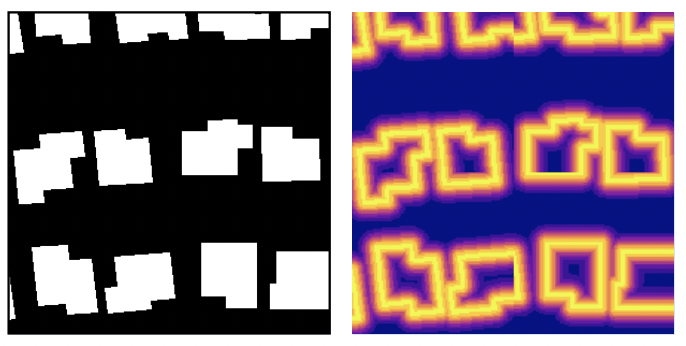

* Create weighted boundary maps for building mask images.

In [ ]:
from pandarallel import pandarallel

# Initialization
pandarallel.initialize(progress_bar=True, nb_workers=8)


def make_weight_map(masks, w0, sigma):
        """
        Generate the weight maps as specified in the UNet paper
        for a set of binary masks.

        Parameters
        ----------
        masks: array-like
            A 3D array of shape (n_masks, image_height, image_width),
            where each slice of the matrix along the 0th axis represents one binary mask.

        Returns
        -------
        array-like
            A 2D array of shape (image_height, image_width)

        """
        nrows, ncols = masks.shape[1:]
        masks = (masks > 0).astype(int)
        distMap = np.zeros((nrows * ncols, masks.shape[0]))
        X1, Y1 = np.meshgrid(np.arange(nrows), np.arange(ncols))
        X1, Y1 = np.c_[X1.ravel(), Y1.ravel()].T
        for i, mask in enumerate(masks):
            # find the boundary of each mask,
            # compute the distance of each pixel from this boundary
            bounds = find_boundaries(mask, mode='inner')
            X2, Y2 = np.nonzero(bounds)
            xSum = (X2.reshape(-1, 1) - X1.reshape(1, -1)) ** 2
            ySum = (Y2.reshape(-1, 1) - Y1.reshape(1, -1)) ** 2
            distMap[:, i] = np.sqrt(xSum + ySum).min(axis=0)
        ix = np.arange(distMap.shape[0])
        if distMap.shape[1] == 1:
            d1 = distMap.ravel()
            border_loss_map = w0 * np.exp((-1 * (d1) ** 2) / (2 * (sigma ** 2)))
        else:
            if distMap.shape[1] == 2:
                d1_ix, d2_ix = np.argpartition(distMap, 1, axis=1)[:, :2].T
            else:
                d1_ix, d2_ix = np.argpartition(distMap, 2, axis=1)[:, :2].T
            d1 = distMap[ix, d1_ix]
            d2 = distMap[ix, d2_ix]
            border_loss_map = w0 * np.exp((-1 * (d1 + d2) ** 2) / (2 * (sigma ** 2)))
        xBLoss = np.zeros((nrows, ncols))
        xBLoss[X1, Y1] = border_loss_map
        # class weight map
        loss = np.zeros((nrows, ncols))
        w_1 = 1 - masks.sum() / loss.size
        w_0 = 1 - w_1
        loss[masks.sum(0) == 1] = w_1
        loss[masks.sum(0) == 0] = w_0
        ZZ = xBLoss + loss
        return ZZ

def resize_mask(mask, resize):
        return interpolate(torch.tensor(mask).unsqueeze(0).unsqueeze(0).float(), size=resize, mode="nearest").detach().numpy()

def create_weight_boundarymaps(row, src_dir, dest_dir, w0, sigma, inc, resize=None):

    if os.path.exists(os.path.join(dest_dir, row["mask"].replace("_mask.npy", "_mask_wt.npy"))):
        return

    mask = np.load(os.path.join(src_dir, row["mask"]))

    mask = (mask > 0).astype(np.int32)

    if resize is not None:
        mask = resize_mask(mask, resize).squeeze().astype(np.int32)

    mask_weight = np.expand_dims(mask, axis=0)
    endpoint = mask.shape[0]
    max_step = int(np.ceil(endpoint / inc))

    for i in range(max_step):
        si, ei = i * inc, min(endpoint, i * inc + inc)

        for j in range(max_step):
            sj, ej = j * inc, min(endpoint, j *  inc + inc)

            if len(np.unique(mask[si:ei, sj:ej])) > 1:
                mask_weight[:, si:ei, sj:ej] = make_weight_map(mask_weight[:, si:ei, sj:ej], w0, sigma)
            else:
                mask_weight[:, si:ei, sj:ej] = 0

    np.save(
        os.path.join(dest_dir, row["mask"].replace("_mask.npy", "_mask_wt.npy")),
        mask_weight.astype(np.uint8).squeeze()
    )


def process_sequentially(df, src_dir, dest_dir, w0, sigma, inc, resize=None):

    masks_path = os.path.join(src_dir, "masks")
    masks_wt_path = os.path.join(dest_dir, "masks_wt")

    os.makedirs(masks_wt_path, exist_ok=True)

    for index, row in tqdm(df.iterrows(), total=len(df)):
        create_weight_boundarymaps(row, masks_path, masks_wt_path, w0, sigma, inc, resize)


def process_parallel(df, src_dir, w0, sigma, inc, resize=None):

    masks_path = os.path.join(src_dir, "masks")
    masks_wt_path = os.path.join(src_dir, "masks_wt")

    os.makedirs(masks_wt_path, exist_ok=True)

    df.parallel_apply(create_weight_boundarymaps, args=(masks_path, masks_wt_path, w0, sigma, inc, resize), axis=1)


process_parallel(train_df, TRAIN_DIR, 5, 3.5, 150, resize=(256, 256))
process_parallel(test_df, VAL_DIR, 5, 3.5, 150, resize=(256, 256))
process_parallel(test_df, VAL_DIR, 5, 3.5, 150, resize=(256, 256))

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Visualize Sample of Images

In [ ]:
sample = train_df.sample(5).reset_index(drop=True)

fig = plt.figure(figsize=(10, 20))
bs = sample.shape[0]

num_cols = 3

for index in range(bs):
    row = sample.loc[index]
    image = row['image']
    mask  = row['mask']
    image_id = image.split(".")[0]

    image = np.array(Image.open(f"{TRAIN_DIR}/images/{image}"))
    target_mask = np.load(f"{TRAIN_DIR}/masks/{mask}")
    boundary_wt_mask = np.load(f"{TRAIN_DIR}/masks_wt/{image_id}.jpg_mask_wt.npy")

    ax = plt.subplot(bs, num_cols, num_cols * index + 1, xticks=[], yticks=[])
    ax.imshow(image)
    ax.set_title(f'Satellite: {image_id}')

    ax = plt.subplot(bs, num_cols, num_cols * index + 2, xticks=[], yticks=[])
    ax.imshow(target_mask)
    ax.set_title('Target Mask')

    ax = plt.subplot(bs, num_cols, num_cols * index + 3, xticks=[], yticks=[])
    ax.imshow(boundary_wt_mask)
    ax.set_title('Boundary Weight Mask')

## DeepLabV3+ with ResNet101 Backbone

DeepLabv3 is a fully Convolutional Neural Network (CNN) model designed by a team of Google researchers to tackle the problem of semantic segmentation. DeepLabv3 is an incremental update to previous (v1 & v2) DeepLab systems and easily outperforms its predecessor.



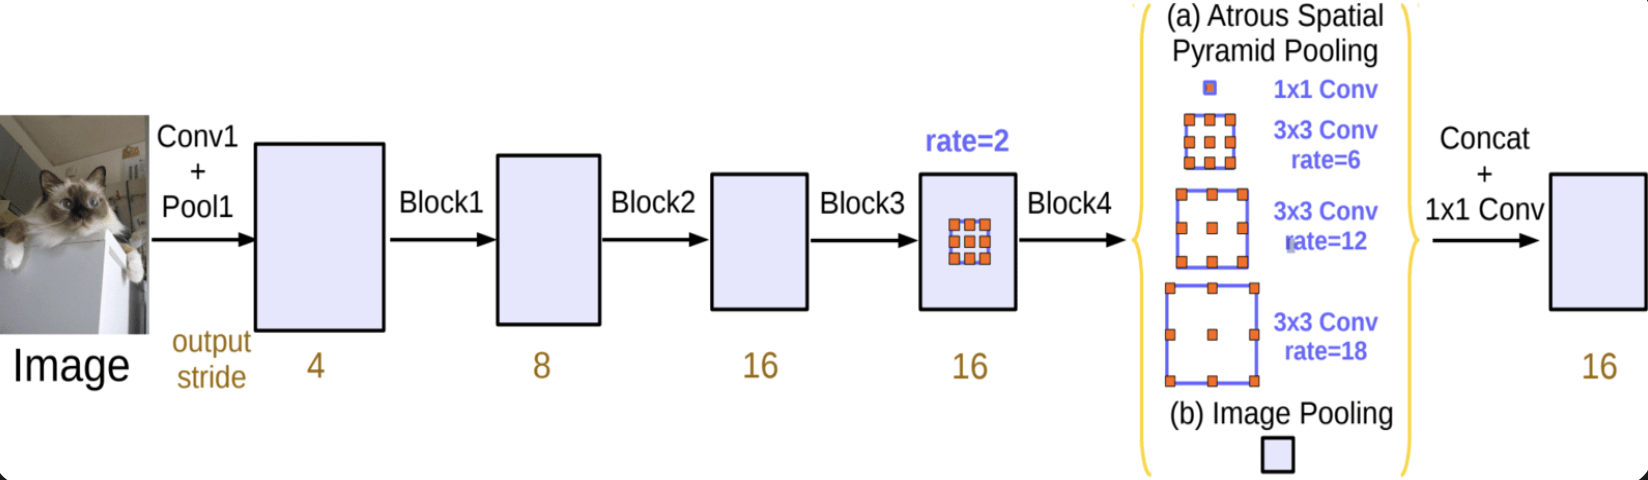

## Resnet101 Backbone

In [ ]:
import math
from torch import nn
import torch.nn.functional as F

# ResNet101 Backbone Network

def ResNet101(pretrained=True):
    """
    pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    return ResNet(Bottleneck, [3, 4, 23, 3], 8, nn.BatchNorm2d, pretrained=pretrained)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None, BatchNorm=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               dilation=dilation, padding=dilation, bias=False)
        self.bn2 = BatchNorm(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = BatchNorm(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, output_stride, BatchNorm, pretrained=True):
        self.inplanes = 64
        super(ResNet, self).__init__()
        blocks = [1, 2, 4]
        if output_stride == 16:
            strides = [1, 2, 2, 1]
            dilations = [1, 1, 1, 2]
        elif output_stride == 8:
            strides = [1, 2, 1, 1]
            dilations = [1, 1, 2, 4]
        else:
            raise NotImplementedError

        # Modules
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                                bias=False)
        self.bn1 = BatchNorm(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=strides[0], dilation=dilations[0], BatchNorm=BatchNorm)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=strides[1], dilation=dilations[1], BatchNorm=BatchNorm)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=strides[2], dilation=dilations[2], BatchNorm=BatchNorm)
        self.layer4 = self._make_MG_unit(block, 512, blocks=blocks, stride=strides[3], dilation=dilations[3], BatchNorm=BatchNorm)
        self._init_weight()

        if pretrained:
            self._load_pretrained_model()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, BatchNorm=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, dilation, downsample, BatchNorm))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation, BatchNorm=BatchNorm))

        return nn.Sequential(*layers)

    def _make_MG_unit(self, block, planes, blocks, stride=1, dilation=1, BatchNorm=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, dilation=blocks[0]*dilation,
                            downsample=downsample, BatchNorm=BatchNorm))
        self.inplanes = planes * block.expansion
        for i in range(1, len(blocks)):
            layers.append(block(self.inplanes, planes, stride=1,
                                dilation=blocks[i]*dilation, BatchNorm=BatchNorm))

        return nn.Sequential(*layers)

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        low_level_feat = x
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x, low_level_feat

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _load_pretrained_model(self):
        pretrain_dict = torch.utils.model_zoo.load_url('https://download.pytorch.org/models/resnet101-5d3b4d8f.pth')
        model_dict = {}
        state_dict = self.state_dict()
        for k, v in pretrain_dict.items():
            if k in state_dict:
                model_dict[k] = v
        state_dict.update(model_dict)
        self.load_state_dict(state_dict)


## ASPP Module:

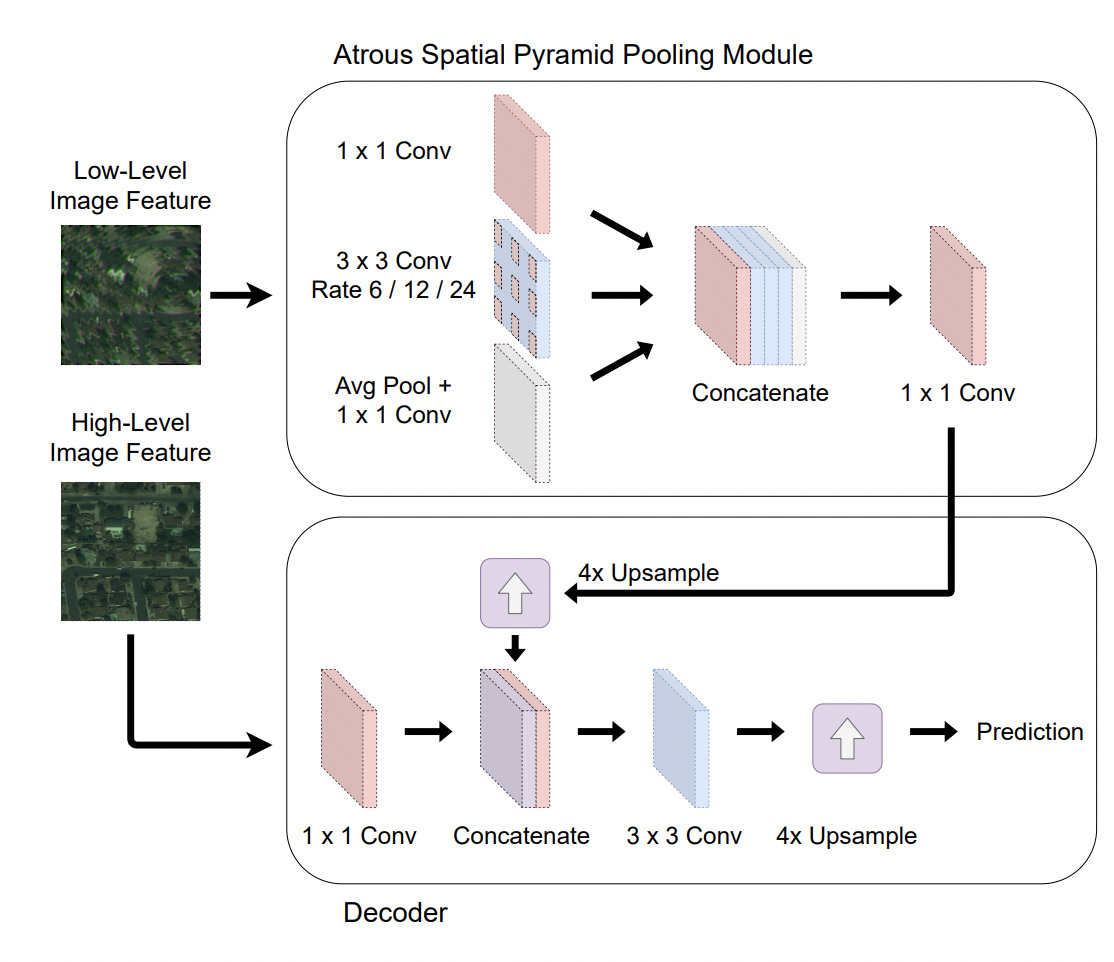

In [ ]:
#ASPP Module

class ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation, BatchNorm):
        super(ASPPModule, self).__init__()
        self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                                            stride=1, padding=padding, dilation=dilation, bias=False)
        self.bn = BatchNorm(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

class ASPP(nn.Module):
    def __init__(self, output_stride, BatchNorm, dropout):
        super(ASPP, self).__init__()

        inplanes = 2048
        if output_stride == 16:
            dilations = [1, 6, 12, 18]
        elif output_stride == 8:
            dilations = [1, 12, 24, 36]
        else:
            raise NotImplementedError

        self.aspp1 = ASPPModule(inplanes, 256, 1, padding=0, dilation=dilations[0], BatchNorm=BatchNorm)
        self.aspp2 = ASPPModule(inplanes, 256, 3, padding=dilations[1], dilation=dilations[1], BatchNorm=BatchNorm)
        self.aspp3 = ASPPModule(inplanes, 256, 3, padding=dilations[2], dilation=dilations[2], BatchNorm=BatchNorm)
        self.aspp4 = ASPPModule(inplanes, 256, 3, padding=dilations[3], dilation=dilations[3], BatchNorm=BatchNorm)

        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(inplanes, 256, 1, stride=1, bias=False),
                                             BatchNorm(256),
                                             nn.ReLU())
        self.conv1 = nn.Conv2d(1280, 256, 1, bias=False)
        self.bn1 = BatchNorm(256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self._init_weight()

    def forward(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        return self.dropout(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


### Decoder Network for Reconstruction of Building Mask Using Learned Features Maps.

In [ ]:
# Decoder Network

class Decoder(nn.Module):
    def __init__(self, num_classes, BatchNorm, dropout_low, dropout_high):
        super(Decoder, self).__init__()

        low_level_inplanes = 256
        self.conv1 = nn.Conv2d(low_level_inplanes, 48, 1, bias=False)
        self.bn1 = BatchNorm(48)
        self.relu = nn.ReLU()

        self.last_conv = nn.Sequential(nn.Conv2d(304, 64, kernel_size=3, stride=1, padding=1, bias=False),
                                       BatchNorm(64),
                                       nn.ReLU(),
                                       nn.Dropout(dropout_high),
                                       nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
                                       BatchNorm(64),
                                       nn.ReLU(),
                                       nn.Dropout(dropout_low),
                                       nn.Conv2d(64, num_classes, kernel_size=1, stride=1))
        self._init_weight()


    def forward(self, x, low_level_feat):
        low_level_feat = self.conv1(low_level_feat)
        low_level_feat = self.bn1(low_level_feat)
        low_level_feat = self.relu(low_level_feat)

        x = F.interpolate(x, size=low_level_feat.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x, low_level_feat), dim=1)
        x = self.last_conv(x)

        return x

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

## DeepLabV3+ Architecture Using above network modules.


In [ ]:
class DeepLab(nn.Module):
    def __init__(self, output_stride=16, num_classes=21, dropout_low=0.1, dropout_high=0.5):

        super(DeepLab, self).__init__()

        self.backbone = ResNet101(pretrained=True)
        self.aspp = ASPP(output_stride, nn.BatchNorm2d, dropout_high)
        self.decoder = Decoder(num_classes, nn.BatchNorm2d, dropout_low, dropout_high)

    def forward(self, input):
        x, low_level_feat = self.backbone(input)

        x = self.aspp(x)
        x = self.decoder(x, low_level_feat)
        x = F.interpolate(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        return x

In [ ]:
model_arch = DeepLab(num_classes=2)

## DNN Layers and the number of trainable params.

In [ ]:
from torchsummary import summary

summary(model_arch, input_size=(3, 256, 256), device="cpu")

# Training the model


#### Set Reproducibility

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(SEED)

#### Define Torch Dataset and Data Augmentation

* We will resize image size to 256 x 256 for model training. You can try larger image size like (512x512, 1024x1024, etc) depending upon your available memory.

In [ ]:
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


class BFPDataset(torch.utils.data.Dataset):

    def __init__(self, df, data_dir, transforms=None):
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def process_boundary(self, image_filename) -> np.ndarray:
        mask_wt = np.load(os.path.join(self.data_dir, "masks_wt", image_filename + "_mask_wt.npy"))

        # scale 0 - 1
        max_value = np.max(mask_wt)
        if max_value > 0:
            mask_wt = mask_wt / max_value

        return mask_wt


    def __getitem__(self, index):
        row = self.df.loc[index]
        image = row['image']
        mask  = row['mask']

        image = np.array(Image.open(f"{self.data_dir}/images/{image}"))
        target_mask = np.array(Image.fromarray(np.load(f"{self.data_dir}/masks/{mask}")))
        boundary_mask = self.process_boundary(row['image'])

        transformed = self.transforms(image=image, mask=target_mask, boundary_mask=boundary_mask)

        image = torch.from_numpy(transformed['image']).permute(2, 0, 1)
        target_mask = torch.from_numpy(transformed['mask']).to(torch.int64)
        boundary_mask = torch.from_numpy(transformed['boundary_mask']).to(torch.float)

        return image, torch.stack([target_mask, boundary_mask])


train_transforms = A.Compose([A.Resize((IMAGE_WIDTH, IMAGE_HEIGHT), p=1),
                              A.HorizontalFlip(p=0.5),
                              A.VerticalFlip(p=0.5),
                              A.Transpose(p=0.3),
                              A.ShiftScaleRotate(p=0.2, scale_limit=0, rotate_limit=0),
                              A.RandomBrightnessContrast(p=0.4),
                              A.OneOf([A.RGBShift(), A.GaussNoise(), A.ISONoise()], p=0.3),
                              A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
                             ],
                            additional_targets={
                                "boundary_mask": "mask"
                            })

val_transforms = A.Compose([
    A.Resize((IMAGE_WIDTH, IMAGE_HEIGHT), p=1),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

#### Define Data Loaders

In [ ]:
BATCH_SIZE = 24
NUM_WORKERS = 64

train_dataset = BFPDataset(train_df, TRAIN_DIR, train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
                                           pin_memory=True, shuffle=True, persistent_workers=True, drop_last=True)

val_dataset = BFPDataset(val_df, VAL_DIR, val_transforms)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
                                           pin_memory=True, shuffle=False, persistent_workers=True)

In [ ]:
iterator = iter(val_loader)
X, target = next(iterator)
X.shape, target.shape

## Define Dice + Weighted Boundary Loss Function:

In [ ]:

class DiceLoss(torch.nn.Module):
    def __init__(self, beta=1, eps=1e-7) -> None:
        super().__init__()
        self.beta = beta
        self.eps = eps

    def forward(self, logit, target):

        logit = F.log_softmax(logit, dim=1).float()
        logit = logit.exp()

        assert len(logit.shape) == 4
        assert len(target.shape) == 3

        encoded_target = logit.detach() * 0
        encoded_target.scatter_(1, target.unsqueeze(1), 1)

        intersection = logit * encoded_target
        numerator = (1 + self.beta**2) * intersection.sum(0).sum(1).sum(1)
        denominator = logit + encoded_target

        denominator = (self.beta**2) * denominator.sum(0).sum(1).sum(1) + self.eps
        loss_per_channel = (1 - (numerator / denominator))

        return loss_per_channel.sum() / logit.size(1)



class WeightedBoundaryCELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logit, target, weights=None):
        n, c, h, w = logit.size()

        logits_log_softmax = F.log_softmax(logit, dim=1).float()
        logits_log_probs = logits_log_softmax.gather(dim=1, index=target.view(n, 1, h, w).long()) #n, 1, h, w

        if weights is None:
            weights = torch.zeros_like(logits_log_probs)
        else:
            weights = weights.unsqueeze(1) # weights arrive as n, h, w

        weights_exp = torch.exp(weights) ** 2 # [0 - 1] --> [1 e**3=20]

        assert weights_exp.size() == logits_log_probs.size()
        logits_weighted_log_probs = (logits_log_probs * weights_exp).view(n, -1)

        # Rescale the weights so loss is in approximately the same interval (distribution of weights may have a lot of variance)
        weighted_loss = logits_weighted_log_probs.sum(1) / weights_exp.view(n, -1).sum(1)

        # Return mini-batch mean
        return -1 * weighted_loss.mean() # log probs are negative for incorrect predictions and 0 for perfect. need to minimize not maximize


class WBCE_DiceLoss(torch.nn.Module):
    def __init__(self, weights: list, beta=1):
        super().__init__()
        self.weights = weights
        self.wce = WeightedBoundaryCELoss()
        self.dice = DiceLoss(beta)

    def forward(self, logit, target):

        boundary_weights = target[:,1,:,:]
        target = target[:,0,:,:].to(torch.int64)

        wce = self.wce(logit, target, weights=boundary_weights)
        dice =  self.dice(logit, target)

        return self.weights[0] * wce + self.weights[1] * dice


## Create Pytorch Lightning Module class

* Configure optimizer, loss function and learning rate scheduler.
* Define training, validation and testing steps.
* Track and log necessary metrics for assessing model performance.

In [ ]:
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score

In [ ]:
from collections import defaultdict

class DeepMLModel(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss = WBCE_DiceLoss(weights=[0.4, 0.6])

        self.activation = torch.nn.Softmax2d()

        self.train_metrics = {
            "train_acc": BinaryAccuracy().cuda(),
            "train_prec": BinaryPrecision().cuda(),
            "train_recall": BinaryRecall().cuda(),
            "train_f1": BinaryF1Score().cuda()
        }

        self.val_metrics = {
            "val_acc": BinaryAccuracy().cuda(),
            "val_prec": BinaryPrecision().cuda(),
            "val_recall": BinaryRecall().cuda(),
            "val_f1": BinaryF1Score().cuda()
        }

        self.test_metrics = {
            "test_acc": BinaryAccuracy().cuda(),
            "test_prec": BinaryPrecision().cuda(),
            "test_recall": BinaryRecall().cuda(),
            "test_f1": BinaryF1Score().cuda()
        }

        self.train_loss_steps = []
        self.val_loss_steps = []

        self.history = defaultdict(list)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = self.loss(logits, y)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.collect_metrics(logits, y, self.train_metrics)
        self.train_loss_steps.append(loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.model.parameters(), lr=1e-3, momentum=0.9)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2,
                                                          cooldown=0,
                                                          min_lr=1e-5)
        return { "optimizer": optimizer,
                 "lr_scheduler":{
                    "scheduler" : lr_scheduler,
                    "monitor": "val_loss",
                    "interval": "epoch",
                    }
                }

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        val_loss = self.loss(logits, y)
        self.log("val_loss", val_loss, on_epoch=True, prog_bar=True, logger=True)
        self.collect_metrics(logits, y, self.val_metrics)
        self.val_loss_steps.append(val_loss)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        test_loss = self.loss(logits, y)
        self.log("test_loss", test_loss, on_epoch=True, prog_bar=True)
        self.collect_metrics(logits, y, self.test_metrics)


    def collect_metrics(self, logits, target, metrics):
        target_mask = target[:,0,:,:]

        output = self.activation(logits)
        probs, indices = torch.max(output, dim=-3)

        self.log_dict({ key: metric(indices, target_mask) for key, metric in metrics.items()}, prog_bar=True, logger=True)


    def on_train_epoch_end(self):
        self.history["train_loss"].append(torch.mean(torch.tensor(self.train_loss_steps)).item())
        for key, metric in self.train_metrics.items():
             self.history[key].append(metric.compute().item())
        self.train_loss_steps = []


    def on_validation_epoch_end(self):
        self.history["val_loss"].append(torch.mean(torch.tensor(self.val_loss_steps)).item())
        for key, metric in self.val_metrics.items():
             self.history[key].append(metric.compute().item())
        self.val_loss_steps = []

## Use Pytorch Lightning Trainer for training a model.

In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import LearningRateMonitor

MODEL_DIR = "./deeplab_bfp_segmentation"

checkpoint_callback = ModelCheckpoint(dirpath=f"{MODEL_DIR}/",
                                      save_top_k=1, monitor="val_loss",
                                      mode="min",
                                      filename="best_val_model-{epoch:02d}-{val_loss:.2f}")

lr_monitor = LearningRateMonitor(logging_interval='epoch')

In [ ]:
trainer = L.Trainer(max_epochs=10, callbacks=[lr_monitor, checkpoint_callback])

model = DeepMLModel(model_arch)

trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# Test the model


In [ ]:
test_dataset = BFPDataset(test_df, VAL_DIR, val_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
                                           pin_memory=True, shuffle=False, persistent_workers=True)

In [ ]:
test_metrics = trainer.test(model, dataloaders=test_loader)
test_metrics

### Visualize Samples of Model Prediction on Test Data

In [ ]:
iterator = iter(test_loader)
X, target = next(iterator)
X.shape, target.shape

In [ ]:
model_arch.eval()
model_arch = model_arch.cuda()
softmax = torch.nn.Softmax2d()
with torch.no_grad():
    logits = model_arch(X.cuda())

probas = softmax(logits).cpu()
probs, indices = torch.max(probas, dim=-3)
indices.shape

In [ ]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225])

samples = 8
fig = plt.figure(figsize=(10, 20))
num_cols = 4

for index in range(samples):
    image =  X[index].permute(1,2,0)

    image = (image * IMAGENET_STD) + IMAGENET_MEAN

    target_mask = target[index][0,:,:]
    boundary_wt_mask = target[index][1,:,:]
    model_output = indices[index]

    ax = plt.subplot(samples, num_cols, num_cols * index + 1, xticks=[], yticks=[])
    ax.imshow(image)
    ax.set_title(f'Satellite')

    ax = plt.subplot(samples, num_cols, num_cols * index + 2, xticks=[], yticks=[])
    ax.imshow(target_mask)
    ax.set_title('Target Mask')

    ax = plt.subplot(samples, num_cols, num_cols * index + 3, xticks=[], yticks=[])
    ax.imshow(boundary_wt_mask)
    ax.set_title('Boundary Weight Mask')

    ax = plt.subplot(samples, num_cols, num_cols * index + 4, xticks=[], yticks=[])
    ax.imshow(model_output)
    ax.set_title('Model Prediction')

# 7. Report the result

1. Plot the training and validation accuracy history.
2. Plot the training and validation loss history.
3. Report the testing accuracy and loss.
4. Show Confusion Matrix for testing dataset.
5. Report values for preformance study metrics like accuracy, precision, recall, F1 Score.


### Training and Validation Accuracy Plot

In [ ]:
##---------Type the code below this line------------------##
plt.plot(range(len(model.history["train_acc"])), model.history["train_acc"], label="Train Acc")
plt.plot(range(len(model.history["val_acc"])), model.history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

### Training and Validation Loss Plot

In [ ]:
##---------Type the code below this line------------------##
plt.plot(range(len(model.history["train_loss"])), model.history["train_loss"], label="Train Loss")
plt.plot(range(len(model.history["val_loss"])), model.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

#### Confusion Matrix on Test Dataset

In [ ]:
from tqdm.auto import tqdm

model_arch.eval()
model_arch = model_arch.cuda()
softmax = torch.nn.Softmax2d()
predictions = []
targets = []
with torch.no_grad():
    for X, target in tqdm(test_loader, total=len(test_loader)):
        logits = model_arch(X.cuda())
        probas = softmax(logits).cpu()
        probs, indices = torch.max(probas, dim=-3)
        predictions.append(indices)
        targets.append(target[:,0,:,:])

outputs = torch.cat(predictions)
targets = torch.cat(targets)

In [ ]:
from torchmetrics.classification import BinaryConfusionMatrix

metric = BinaryConfusionMatrix()
metric.update(outputs, targets)

metric.plot()

### Test Metrics: Precision, Recall, F1_Score and Accuracy

In [ ]:
print("Test Precision:", test_metrics[0]["test_prec"])
print("Test Recall:", test_metrics[0]["test_recall"])
print("Test F1 Score:", test_metrics[0]["test_f1"])
print("Test Accuracy :", test_metrics[0]["test_acc"])